# HERA Memo - Mapping HERA's Primary Beam
### Tyler Cox

This notebook is being used to study the shape of HERA's beam, that is, the sensitivity of HERA as a function of angle from the zenith. We'll start by importing all of the necessary packages.

## 1. Imaging IDR2.1 Data
What to explain:
- Short description of the data being used
- Process used to produce the images
- Full time integration images vs. time split images

In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from astropy.wcs import WCS
from astropy.io import fits
from astropy import units as u
from astropy.visualization.wcsaxes import WCSAxes
from HERA_calibration_sources import add_fluxes
from pyuvdata import UVBeam
import healpy as hp

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')

In [2]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [3]:
freq_range = 'IDR2.1_3.1'

files = np.sort(glob('/data6/HERA/HERA_imaging/IDR2/IDR2-1_run_3.1/imgs/*fits'))
HDUS = []
for f in files:
    HDUS.append(fits.open(f))
    
d = HDUS[0][0].data[0][0]

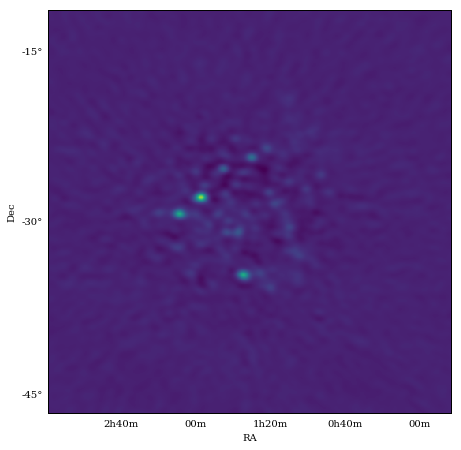

In [4]:
fig = plt.figure(figsize=(10,7))
wcs = WCS(HDUS[0][0].header).celestial
ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8], wcs=wcs)
fig.add_axes(ax)
data = HDUS[0][0].data.squeeze()
img = ax.imshow(data,vmin=d.min(),vmax=1.2*d.max(),origin='lower')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('hh:mm')
lon.set_ticks(spacing=10 * u.degree, color='white', exclude_overlapping=True)
lat.set_ticks(spacing=15 * u.degree, color='white', exclude_overlapping=True)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

## 2. Modeling HERA's Beam
What to explain:
- Description of the simulation used
- Process of pulling out the tracks need
- Averaging across frequency

In [5]:
hera_beam = UVBeam() #Instantiating HERA's beam as a UVBeam object
hera_beam.read_beamfits("NF_HERA_power_beam_healpix.fits") #Reading in the beam model

In [6]:
def hera_beam_freq_slice(hera_beam, freq, beam_center = 90, ang_from_center = 15, n = 100):
    ang = np.linspace(beam_center-ang_from_center,beam_center+ang_from_center,n)
    beam_slice     = []
    beam_map       = hera_beam.data_array[0][0][0][freq-100]
    beam_map_norm  = beam_map/np.max(beam_map) 
    for i in ang:
        beam_slice.append(hp.get_interp_val(beam_map_norm,0, i, lonlat=True))  
    return ang, np.array(beam_slice)

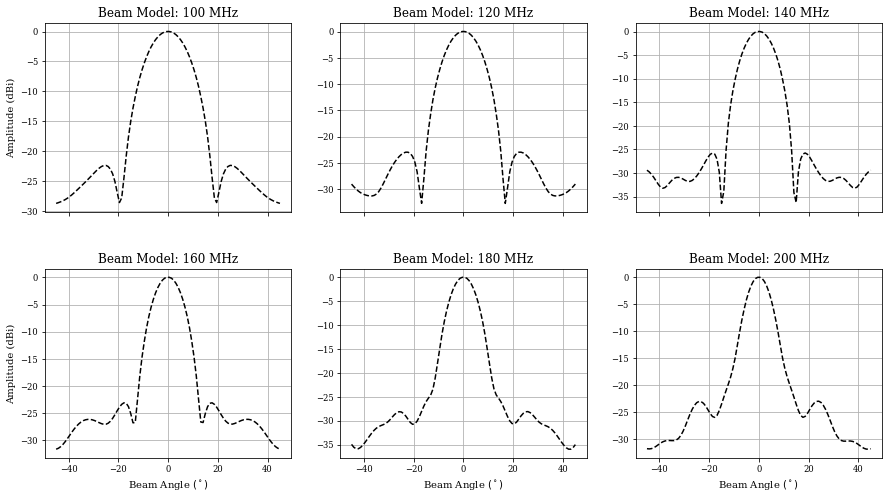

In [7]:
freqs = np.array([100,120,140,160,180,200])
model_beam = np.zeros(100)

fig, axs = plt.subplots(2,3, figsize=(15, 8), facecolor='w', edgecolor='k',sharex='col')
fig.subplots_adjust(hspace = .3)

axs = axs.ravel()

for i,freq in enumerate(freqs):
    ang, beam = hera_beam_freq_slice(hera_beam, freq, ang_from_center=45, n=100)
    model_beam = 10*np.log10(beam)
    axs[i].plot(ang-90,model_beam,'k--')
    axs[i].set_title('Beam Model: ' + str(freq) + ' MHz')
    axs[i].grid()
    if i > 2:
        axs[i].set_xlabel('Beam Angle $(^\circ)$')
    if i == 0 or i == 3:
        axs[i].set_ylabel('Amplitude (dBi)')


plt.show()

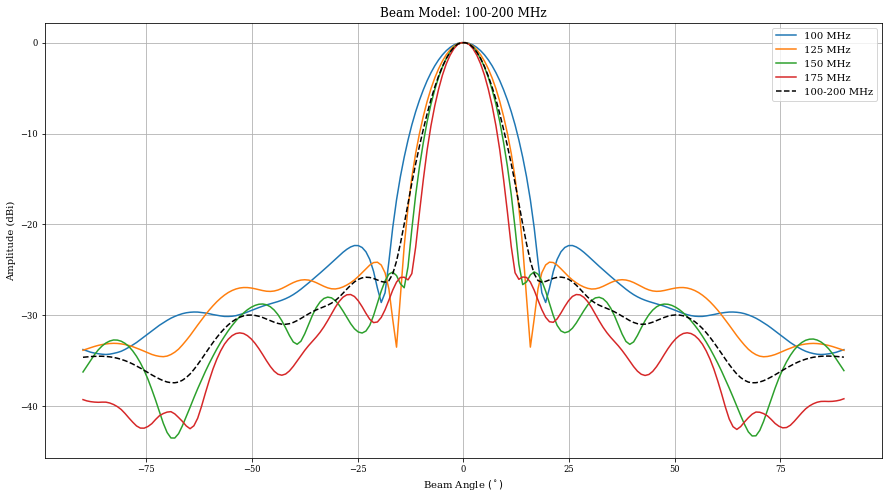

In [8]:
freqs = np.arange(100,200)
model_beam = np.zeros(200)

plt.figure(figsize=(15,8))

for freq in freqs:
    ang, beam = hera_beam_freq_slice(hera_beam, freq, ang_from_center=90, n=200)
    model_beam += beam
    if freq%25 == 0:
        plt.plot(ang-90,10*np.log10(beam),label=(str(freq) + ' MHz'))
        
model_beam /= freqs.shape[0]
model_beam = 10*np.log10(model_beam)

plt.xlabel(r'Beam Angle $(^\circ)$')
plt.ylabel(r'Amplitude (dBi)')
plt.title(r'Beam Model: 100-200 MHz')
plt.plot(ang-90,model_beam,'k--', label = '100-200 MHz')
plt.grid()
plt.legend()
plt.show()

## 3. Tracking Extragalactic Sources
What to explain:
- Using Lily's code to find sources within the field of view
- Reading in fits files
- Using the right ascension and declination to track sources in the images
- Record their flux and divide by known values and plot

Now, we need to pull in the data from the images that we've already generated. To do this, the glob package is used to search for all of the fits files we need to do the mapping. For now, we'll look at sources that we imaged in the 110-120 MHz range. Once glob collects the files, they are sorted, opened, and added to a list for later use

We then use the HERA_calibration_sources package to find bright sources within our field of view which we will track and use to 

In [9]:
tb = add_fluxes(RA_range=('00:00:00','13:00:00'),dec_range=1, min_flux=6)
tb

,Name of Center,RA,Dec,Total flux in region
0,TGSSADR J020012.1-305327,30.050440,-30.891060,25311.699249
1,TGSSADR J043300.3-295615,68.251488,-29.937559,10452.800014
2,TGSSADR J043736.5-295406,69.402321,-29.901720,9057.500076
3,TGSSADR J045826.4-300720,74.610413,-30.122379,19984.100246
4,TGSSADR J045514.2-300650,73.809464,-30.113991,23645.400387
5,TGSSADR J051330.6-303042,78.377602,-30.511909,18364.499821
6,TGSSADR J073819.7-302505,114.582474,-30.418230,14347.499702
7,TGSSADR J082126.4-301105,125.360031,-30.184980,20358.700781


In [10]:
def track_sources(files,tb):
    err = 3
    t = 0
    plot_data = {v['Name of Center']: {'RA_diff': [], 'Flux': [], 'Center_RA': []} for _,v in tb.iterrows()}
    
    for f in files:
        with fits.open(f) as HDU:
            # Read in file information
            #print f

            fits_info = HDU[0].header
            ax1        = fits_info['NAXIS1']
            ax2        = fits_info['NAXIS2']
            c_ra       = fits_info['OBSRA']
            c_dec      = fits_info['OBSDEC']
            pix_size   = abs(fits_info['CDELT1'])

            # Flip to data to correct the axes
            data = HDU[0].data
            data = np.flip(data[0][0],axis=0)

            w = WCS(f)
            t += 1

            for _,src in tb.iterrows():

                # Convert a position to pixel values
                idx_1,idx_2 = w.all_world2pix(src['RA'],src['Dec'],0,0,0)[:2]

                if not np.isnan(idx_1) and not np.isnan(idx_2):
                    idx_1 = int(idx_1)
                    idx_2 = int(ax2-idx_2)


                # ax1 is the right-most pixel, ax2 is the bottom-most pixel
                # we want to make sure that the both values are within the
                # correct range

                if (err < idx_1 < ax1-err) and (err < idx_2 < ax2-err):

                    max_flux = np.abs(data[idx_2-err:idx_2+err,idx_1-err:idx_1+err]).max()
                    plot_data[src['Name of Center']]['Flux'].append(max_flux/src['Total flux in region'])
                    ra_diff = c_ra-src['RA']

                    # Correct for the difference in c_ra error
                    if ra_diff > pix_size*ax1:
                        ra_diff -= 360
                    if ra_diff < -pix_size*ax1:
                        ra_diff += 360

                    plot_data[src['Name of Center']]['RA_diff'].append(ra_diff)
                    plot_data[src['Name of Center']]['Center_RA'].append(t)
    return plot_data

In [11]:
def observed_beam(cleaned_set, n = 77): 
    obs_beam = np.zeros(n)
    c = 0

    for key,item in cleaned_set.items():
        flux = np.array(item['Flux'])
        theta = item['RA_diff']
        if len(flux) == n:
            obs_beam += flux
            c += 1

    obs_beam /= c
    obs_beam /= obs_beam.max()
    obs_beam = 10*np.log10(obs_beam)

    f = np.vstack([10*np.log10(item['Flux']) for key,item in cleaned_set.items() if len(item['Flux'])==n])
    obs_std = np.array([np.std(f[:,i]) for i in range(f.shape[1])])

    return theta, obs_beam, obs_std

In [12]:
freq_range = '170-190MHz'
freq_ends = [170,190]
    
files = np.sort(glob('/data6/HERA/HERA_imaging/IDR2/170-190MHz/imgs/*fits'))
plot_data = track_sources(files,tb)
cleaned_set = {k: v for k,v in plot_data.iteritems() if len(v['Flux']) == 77}

freqs = np.arange(freq_ends[0],freq_ends[1])
model_beam = np.zeros(100)

for freq in freqs:
    ang, beam = hera_beam_freq_slice(hera_beam, freq, ang_from_center=15, n=100)
    model_beam += beam

model_beam /= freqs.shape[0]
model_beam /= model_beam.max()
model_beam = 10*np.log10(model_beam)

theta, obs_beam, obs_std = observed_beam(cleaned_set)

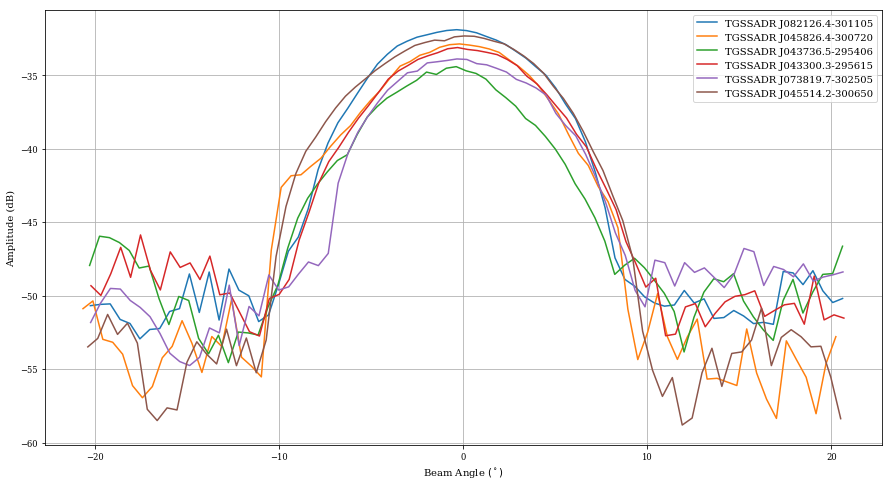

In [19]:
plt.figure(figsize=(15,8))

for key,item in cleaned_set.items():
    flux = np.array(item['Flux'])
    plt.plot(item['RA_diff'],10*np.log10(flux),label=key)
    
plt.xlabel(r'Beam Angle $(^\circ)$')
plt.ylabel(r'Amplitude (dB)')
plt.legend()
plt.grid()
plt.show()

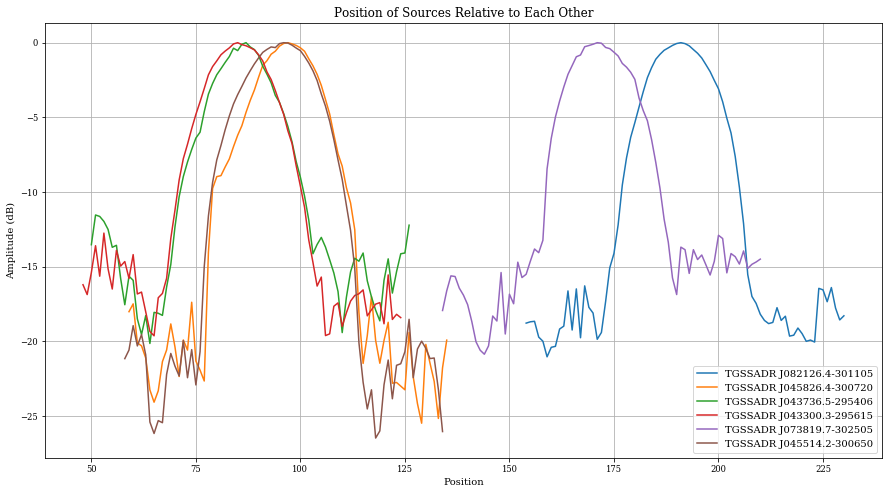

In [14]:
plt.figure(figsize=(15,8))

for key,item in cleaned_set.items():
    flux = np.array(item['Flux'])
    plt.plot(item['Center_RA'],10*np.log10(flux/flux.max()),label=key)
    
plt.title('Position of Sources Relative to Each Other')
plt.xlabel(r'Position')
plt.ylabel('Amplitude (dB)')
plt.legend()
plt.grid()
plt.show()

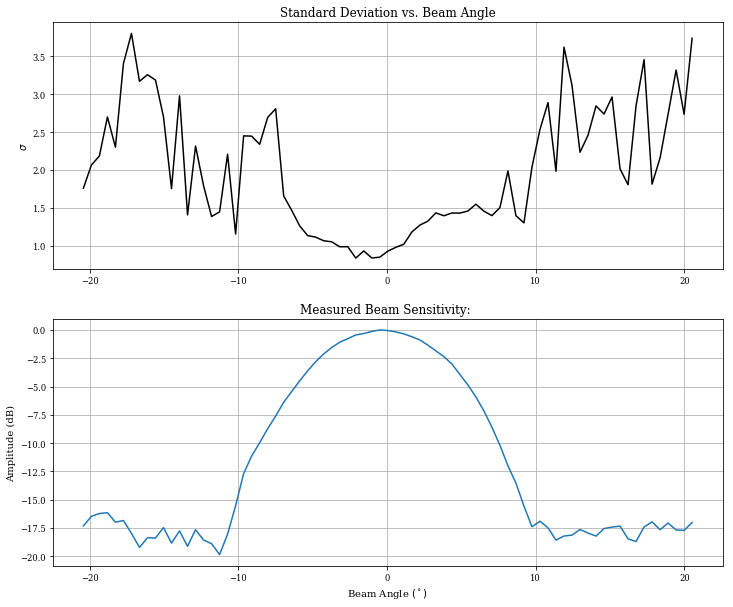

In [15]:
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)

plt.plot(theta,obs_std,'k')
plt.title(r'Standard Deviation vs. Beam Angle')
plt.ylabel(r'$\sigma$')
plt.grid()

plt.subplot(2,1,2)

plt.xlabel(r'Beam Angle $(^\circ)$')
plt.ylabel('Amplitude (dB)')
plt.title('Measured Beam Sensitivity: ')
plt.plot(theta, obs_beam)
plt.grid()
plt.show()

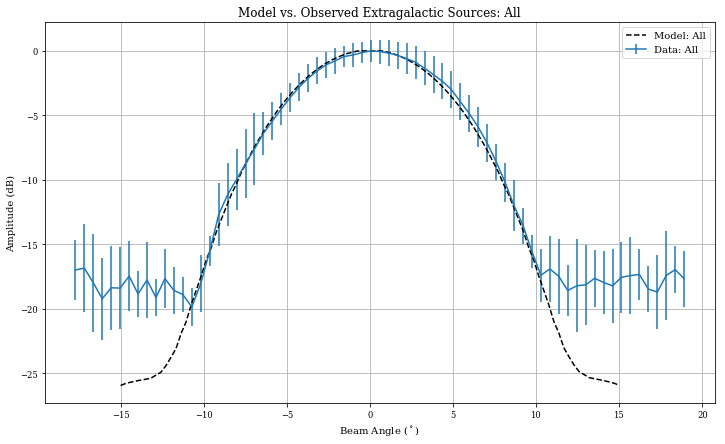

In [16]:
plt.figure(figsize=(12,7))

freq_range = 'All'

plt.plot(ang-90,model_beam,'k--',label=(r'Model: ' + freq_range))
plt.errorbar(theta[5:-3],obs_beam[4:-4],yerr=obs_std[4:-4],label='Data: ' + freq_range)
plt.legend()
plt.title('Model vs. Observed Extragalactic Sources: ' + freq_range)
plt.xlabel(r'Beam Angle ($^\circ$)')
plt.ylabel('Amplitude (dB)')
plt.grid()
plt.show()

In [17]:
freq_range = ['110-130MHz','130-150MHz','150-170MHz','170-190MHz']
freq_ends = [[110,130],[130,150],[150,170],[170,190]]

fig, axs = plt.subplots(2,2, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3)

axs = axs.ravel()

for i,freq_set in enumerate(freq_range):
    
    files = np.sort(glob('/data6/HERA/HERA_imaging/IDR2/' + freq_set + '/imgs/*fits'))
    plot_data = track_sources(files,tb)
    cleaned_set = {k: v for k,v in plot_data.iteritems() if len(v['Flux']) == 77}

    freqs = np.arange(freq_ends[i][0],freq_ends[i][1])
    model_beam = np.zeros(100)
    
    for freq in freqs:
        ang, beam = hera_beam_freq_slice(hera_beam, freq, ang_from_center=15, n=100)
        model_beam += beam

    model_beam /= freqs.shape[0]
    model_beam /= model_beam.max()
    model_beam = 10*np.log10(model_beam)
    
    theta, obs_beam, obs_std = observed_beam(cleaned_set)
    
    axs[i].plot(ang-90,model_beam,'k--',label=(r'Model: ' + freq_set))
    axs[i].errorbar(theta[5:-3],obs_beam[4:-4],yerr=obs_std[4:-4],label='Data: ' + freq_set)
    axs[i].set_title(freq_set)
    axs[i].grid()
    axs[i].set_ylim([-25,5])
    axs[i].set_xlabel(r'Beam Angle ($^\circ$)')
    axs[i].set_ylabel(r'Amplitude (dB)')
    
#plt.tight_layout()
plt.show()
#plt.savefig('10_MHz_chunks.pdf',dpi=300,format='pdf')   

KeyboardInterrupt: 

In [ ]:
freq_range = ['110-120MHz','120-130MHz','130-140MHz','140-150MHz','150-160MHz','160-170MHz','170-180MHz','180-190MHz']
freq_ends = [[110,120],[120,130],[130,140],[140,150],[150,160],[160,170],[170,180],[180,190]]

fig, axs = plt.subplots(4,2, figsize=(15, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3)

axs = axs.ravel()

for i,freq_set in enumerate(freq_range):
    
    files = np.sort(glob('/data6/HERA/HERA_imaging/IDR2/' + freq_set + '/imgs/*fits'))
    plot_data = track_sources(files,tb)
    cleaned_set = {k: v for k,v in plot_data.iteritems() if len(v['Flux']) == 77}

    freqs = np.arange(freq_ends[i][0],freq_ends[i][1])
    model_beam = np.zeros(100)
    
    for freq in freqs:
        ang, beam = hera_beam_freq_slice(hera_beam, freq, ang_from_center=15, n=100)
        model_beam += beam

    model_beam /= freqs.shape[0]
    model_beam /= model_beam.max()
    model_beam = 10*np.log10(model_beam)
    
    theta, obs_beam, obs_std = observed_beam(cleaned_set)
    
    if i == 5:
        obs_beam -= 0.5
    
    if i == 6:
        obs_beam -= 0.75
        
    if i == 7:
        obs_beam -= 1
    
    
    axs[i].plot(ang-90,model_beam,'k--',label=(r'Model: ' + freq_set))
    axs[i].errorbar(theta[5:-3],obs_beam[4:-4],yerr=obs_std[4:-4],label='Data: ' + freq_set)
    axs[i].set_title(freq_set)
    axs[i].grid()
    axs[i].set_ylim([-25,5])
    
    if i > 5:
        axs[i].set_xlabel(r'Beam Angle ($^\circ$)')
    
    if i % 2 == 0:
        axs[i].set_ylabel(r'Amplitude (dBi)')
    
#plt.tight_layout()
plt.show()
#plt.savefig('10_MHz_chunks.pdf',dpi=300,format='pdf')   

## 4. Future Work
- Investigate the cause of the dips in the higher frequency 10 MHz chunks
    - Current IDR2.1 images used a briggs weighting parameter in the CASA CLEAN task that is shifted more closely to uniform. Test the effect of imaging with uniform and natural weighting on the shape of the observed beam.
- Model the noise level for certain frequencies to test whether or not I'm actually hitting the noise level

In [ ]:
np.log10(-1)

In [ ]:
a = np.array([1,2,-1,4,3,5,-5])
a[a < 0] = 0
a